In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os
import re
import numpy as np
import matplotlib as plt
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Subset
from PIL import Image
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.model_selection import GroupShuffleSplit

class SegmentationDataset(Dataset):
    def __init__(self):
        self.base_folder_path = '/content/drive/MyDrive/OSLAM_result'
        self.map_list = []
        self.gt_list = []
        self.wind_list = []
        self.encounter_list=[]
        self.map_origin_list=[]
        self.group_labels = []  # for group label, data from same epoch will not be devide to both train/val set, to avoid data leakage

        self.epoch_range = 60#len(os.listdir(self.base_folder_path))

        for epoch_num in range(1,self.epoch_range+1):
            folder_path = os.path.join(self.base_folder_path, f'epoch{epoch_num}')
            map_files = sorted([f for f in os.listdir(folder_path) if re.match(r'^map_proceeded_\d+\.txt$', f)])
            map_files_origin=sorted([f for f in os.listdir(folder_path) if re.match(r'^map\d+\.txt$', f)])
            label_files = sorted([f for f in os.listdir(folder_path) if re.match(r'^label\d+\.txt$', f)])
            wind_files = sorted([f for f in os.listdir(folder_path) if re.match(r'^wind_\d+\.txt$', f)])
            tf_files = sorted([f for f in os.listdir(folder_path) if re.match(r'^baselink_to_map_\d+\.txt$', f)])

            for j in range(len(map_files)):
                resolution, width, height, data, origin = self.read_map_file(os.path.join(folder_path, map_files[j]))
                target_shape = (279, 279)
                padding = ((0, target_shape[0] - data.shape[0]), (0, target_shape[1] - data.shape[1]))
                padded_map = np.pad(data, padding, mode='constant', constant_values=-1.0)
                self.map_list.append(padded_map)
                encounters=np.zeros(target_shape, dtype=int)
                for i in range(padded_map.shape[0]):
                  for q in range(padded_map.shape[1]):
                    if padded_map[i, q] == 233:
                      encounters[i, q] = 1
                      #print(1)
                self.encounter_list.append(encounters)
                resolution, width, height, data, origin = self.read_map_file(os.path.join(folder_path, map_files_origin[j]))

                padded_map_origin = np.pad(data, padding, mode='constant', constant_values=-1.0)
                self.map_origin_list.append(padded_map_origin)


                resolution, width, height, data, origin = self.read_map_file(os.path.join(folder_path, label_files[j]))
                padded_label = np.pad(data, padding, mode='constant', constant_values=0.0)
                self.gt_list.append(padded_label)

                windpath = os.path.join(folder_path, wind_files[j])
                mappath = os.path.join(folder_path, map_files[j])
                tfpath = os.path.join(folder_path, tf_files[j])
                windmap = np.zeros((279,279))
                for h in range(0,j+1):
                  windpath = os.path.join(folder_path, wind_files[h])
                  tfpath = os.path.join(folder_path, tf_files[h])
                  #mappath = os.path.join(folder_path, map_files_origin[h])


                  with open(windpath, 'r') as file:
                      lines = file.readlines()
                  wind = lines[0]

                  if wind == '0,0':
                      windmap1 = np.zeros((279,279))
                  else:
                      resolution, width, height, data, origin = self.read_map_file(mappath)
                      windmap1 = np.zeros_like(data)
                      self.modify_map(windmap1, width, height, tfpath, resolution, origin)
                      padding = ((0, target_shape[0] - windmap1.shape[0]), (0, target_shape[1] - windmap1.shape[1]))
                      padded_map = np.pad(windmap1, padding, mode='constant', constant_values=0)
                      x, y, X, Y, Z, W = self.read_baselink_to_map_file(tfpath)

                      ang = -np.radians(int(wind.split(",")[1]))
                      ang_wd = self.sensor_direction_in_world(X,Y,Z,W,ang)
                      marked_map = self.mark_wind_direction(padded_map, ang_wd)
                      windmap1 = marked_map
                  windmap+=windmap1

                self.wind_list.append(windmap)

                # add group label
                self.group_labels.append(epoch_num)

        # data enhancement
        map_list_aug1 = [np.rot90(array, k=1).copy() for array in self.map_list]
        gt_list_aug1 = [np.rot90(array, k=1).copy() for array in self.gt_list]
        wind_list_aug1 = [np.rot90(array, k=1).copy() for array in self.wind_list]
        map_origin_aug1=[np.rot90(array, k=1).copy() for array in self.map_origin_list]
        encounters_aug1=[np.rot90(array, k=1).copy() for array in self.encounter_list]

        map_list_aug2 = [np.rot90(array, k=2).copy() for array in self.map_list]
        gt_list_aug2 = [np.rot90(array, k=2).copy() for array in self.gt_list]
        wind_list_aug2 = [np.rot90(array, k=2).copy() for array in self.wind_list]
        map_origin_aug2=[np.rot90(array, k=2).copy() for array in self.map_origin_list]
        encounters_aug2=[np.rot90(array, k=2).copy() for array in self.encounter_list]

        map_list_aug3 = [np.rot90(array, k=3).copy() for array in self.map_list]
        gt_list_aug3 = [np.rot90(array, k=3).copy() for array in self.gt_list]
        wind_list_aug3 = [np.rot90(array, k=3).copy() for array in self.wind_list]
        map_origin_aug3=[np.rot90(array, k=3).copy() for array in self.map_origin_list]
        encounters_aug3=[np.rot90(array, k=3).copy() for array in self.encounter_list]

        # add enhenced data
        self.map_list += map_list_aug1 + map_list_aug2 + map_list_aug3
        self.gt_list += gt_list_aug1 + gt_list_aug2 + gt_list_aug3
        self.wind_list += wind_list_aug1 + wind_list_aug2 + wind_list_aug3
        self.map_origin_list += map_origin_aug1 + map_origin_aug2 + map_origin_aug3
        self.encounter_list += encounters_aug1 + encounters_aug2 + encounters_aug3

        # add group label for enhenced data
        self.group_labels += self.group_labels * 3


    def read_map_file(self, file_path):
        with open(file_path, 'r') as file:
            lines = file.readlines()

        resolution = float(lines[0].split(': ')[1])
        width = int(lines[1].split(': ')[1])
        height = int(lines[2].split(': ')[1])

        origin_x = float(lines[4].split(': ')[1])
        origin_y = float(lines[5].split(': ')[1])

        data_start_index = lines.index('Data:\n') + 1
        data = []
        for line in lines[data_start_index:]:
            data.extend([float(value) for value in line.split()])

        data = np.array(data, dtype=np.float32).reshape((height, width))
        return resolution, width, height, data, {'x': origin_x, 'y': origin_y}

    def convert_coordinates(self, x, y, resolution, origin):
        x_map = round((x - origin['x']) / resolution)
        y_map = round((y - origin['y']) / resolution)
        return x_map, y_map

    def visualize_map(data):

        plt.figure(figsize=(10, 10))

        # represnet unknown area with black
        data_viz = np.copy(data)
        data_viz[data == -1] = np.nan  # assign NaN to unknown area
        im = plt.imshow(data_viz, cmap='gray_r', origin='lower')


        plt.imshow(np.where(np.isnan(data_viz), 0, np.nan), cmap=mcolors.ListedColormap(['black']), origin='lower', alpha=1.0)

        # gas encounter location marked as 233
        y_indices, x_indices = np.where(data == 233)
        plt.scatter(x_indices, y_indices, marker='*', color='red', s=200, label='Plume Encounter')

        # colorbar
        cbar = plt.colorbar(im)
        cbar.set_ticks([0, 116, 233])
        cbar.set_ticklabels(['Free', 'Partially Occupied', 'Occupied'], fontsize=14)

        plt.legend(loc='upper right', fontsize=18)
        plt.show()

    def visualize_label_map(data,save=False):

        plt.figure(figsize=(8, 8))
        plt.imshow(data, cmap='Reds', origin='lower')
        plt.colorbar(label='Labeled Value')
        if save:
            output_path = file_path.replace('.txt', '_visualization.png')
            plt.savefig(output_path, dpi=300)
        plt.show()


    def read_baselink_to_map_file(self, file_path):
        with open(file_path, 'r') as file:
            lines = file.readlines()

        for line in lines:
            if 'translation:' in line:
                x = float(lines[lines.index(line) + 1].split(': ')[1])
                y = float(lines[lines.index(line) + 2].split(': ')[1])

            if "rotation:" in line:
                X=float(lines[lines.index(line) + 1].split(': ')[1])
                Y=float(lines[lines.index(line) + 2].split(': ')[1])
                Z=float(lines[lines.index(line) + 3].split(': ')[1])
                W=float(lines[lines.index(line) + 4].split(': ')[1])


        return x, y, X,Y,Z,W


    def modify_map(self, map_data, width, height, baselink_file, resolution, origin):

        x, y, X,Y,Z,W = self.read_baselink_to_map_file(baselink_file)
        x_map, y_map = self.convert_coordinates(x, y, resolution, origin)

        if 0 <= x_map < width and 0 <= y_map < height:
            map_data[y_map, x_map] = 1
        else:
            print(f"Warning: Coordinate ({x_map}, {y_map}) is out of bounds for map size ({width}, {height}).")


    def mark_wind_direction(self, array, radians):

        position = np.argwhere(array == 1)
        if len(position) == 0:
            raise ValueError("Array must contain exactly one '1'.")

        pos_x, pos_y = position[0]

        # generate wind vector

        #wind_vector = np.array([np.cos(radians), np.sin(radians)])
        wind_vector = np.array([np.sin(radians), np.cos(radians)])


        rows, cols = array.shape

        for i in range(rows):
            for j in range(cols):
                if (i, j) == (pos_x, pos_y):
                    continue


                grid_vector = np.array([i - pos_x, j - pos_y])


                dot_product = np.dot(grid_vector, wind_vector)


                if dot_product < 0:
                    array[i, j] = -1  # downwind
                else:
                    array[i, j] = 1  # upwind

        return array


    def sensor_direction_in_world(self, x, y, z, w, a):
        """
        计算传感器观测到的方向在世界坐标系下的角度值。

        parameters:
        x, y, z, w - rotation from robot coordinate to world。
        a - The sensor reading is the observed Angle value (radian) of rotation clockwise from the direction pointed by the robot.

        return:
        The Angle value (radian) of the sensor's observation direction in the world coordinate system.
        """

        # Create a rotating object representing the transformation of the robot to the world coordinate system
        r = R.from_quat([x, y, z, w])

        # The direction vector of the sensor in the robot coordinate system

        sensor_direction_robot = np.array([np.cos(a), np.sin(a), 0])

        # The direction vector of the sensor in the robot coordinate system
        sensor_direction_world = r.apply(sensor_direction_robot)

        yaw_world = np.arctan2(sensor_direction_world[1], sensor_direction_world[0])

        return yaw_world

    def __len__(self):
        return len(self.map_list)

    def __getitem__(self, idx):
        #current_map = np.stack([self.map_list[idx], self.wind_list[idx]], axis=0)
        current_map_3d = np.stack([self.map_origin_list[idx], self.wind_list[idx], self.encounter_list[idx]], axis=0)

        gt = self.gt_list[idx]  # Shape: [279, 272] (no channel dimension)
        #return torch.tensor(current_map_3d, dtype=torch.float32), torch.tensor(gt, dtype=torch.float32)
        return torch.tensor(current_map_3d, dtype=torch.float32), torch.tensor(gt, dtype=torch.float32)
full_dataset = SegmentationDataset()
print(len(full_dataset))  # sample number
print(len(full_dataset.group_labels))  # label number


956
956


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100], Train Loss: 0.7278, Val Loss: 0.6917
Epoch [2/100], Train Loss: 0.6447, Val Loss: 0.6258
Epoch [3/100], Train Loss: 0.5961, Val Loss: 0.5871
Epoch [4/100], Train Loss: 0.5628, Val Loss: 0.5570
Epoch [5/100], Train Loss: 0.5376, Val Loss: 0.5368
Epoch [6/100], Train Loss: 0.5180, Val Loss: 0.5185
Epoch [7/100], Train Loss: 0.5021, Val Loss: 0.5017
Epoch [8/100], Train Loss: 0.4878, Val Loss: 0.4882
Epoch [9/100], Train Loss: 0.4758, Val Loss: 0.4729
Epoch [10/100], Train Loss: 0.4628, Val Loss: 0.4649
Epoch [11/100], Train Loss: 0.4483, Val Loss: 0.4526
Epoch [12/100], Train Loss: 0.4351, Val Loss: 0.4438
Epoch [13/100], Train Loss: 0.4225, Val Loss: 0.4314
Epoch [14/100], Train Loss: 0.4117, Val Loss: 0.4298
Epoch [15/100], Train Loss: 0.4028, Val Loss: 0.4151
Epoch [16/100], Train Loss: 0.3947, Val Loss: 0.4170
Epoch [17/100], Train Loss: 0.3877, Val Loss: 0.4178
Epoch [18/100], Train Loss: 0.3804, Val Loss: 0.3977
Epoch [19/100], Train Loss: 0.3739, Val Loss: 0.3923
Ep

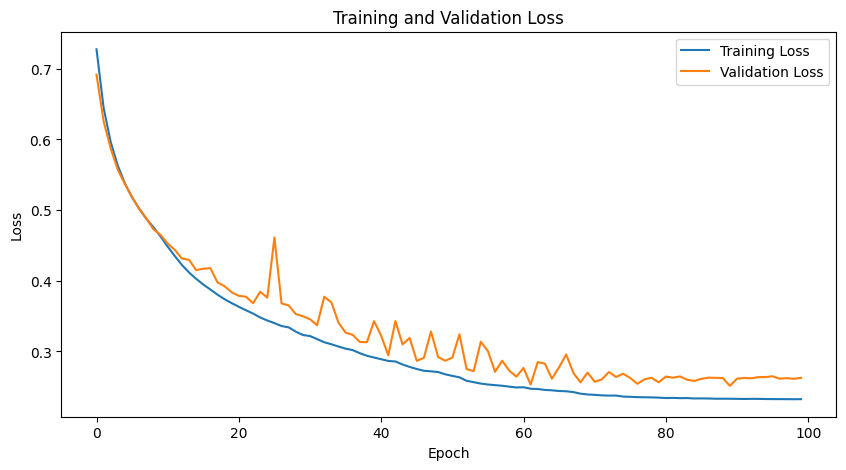

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self, positive_weight=1.0):
        super(CustomLoss, self).__init__()
        self.positive_weight = positive_weight
        self.cross_entropy_loss = nn.BCELoss(reduction='none')
        #self.mseloss=nn.MSELoss()

    def forward(self, output, target):

        output = torch.clamp(output, 0, 1)
        target = torch.clamp(target, 0, 1)

        # BCELoss
        y1 = torch.ones_like(target)  # y=1
        y0 = torch.zeros_like(target)  # y=0


        ce_loss_y1 = self.cross_entropy_loss(output, target)
        ce_loss_y0 = self.cross_entropy_loss(output, target)


        #y!=0
        mask = target != 0
        weighted_loss = ce_loss_y1 * self.positive_weight * (target**0.2)

        # y=0
        loss = torch.where(mask, weighted_loss, ce_loss_y0)

        # total loss
        final_loss = loss.mean()

        return final_loss

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        logits = torch.sigmoid(logits)  #Sigmoid
        return logits



full_dataset = SegmentationDataset()

#  GroupShuffleSplit divide by label
splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, val_indices = next(splitter.split(X=range(len(full_dataset)), groups=full_dataset.group_labels))


train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)


train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(3, 1).to(device)

criterion=CustomLoss(positive_weight=5.0)

optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

train_losses = []
val_losses = []
num_epochs = 100
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    epoch_loss = 0
    for images, masks in train_dataloader:
        images = images.to(device)
        #print(images.size())
        masks = masks.to(device)

        outputs = model(images)

        masks = masks.unsqueeze(1)
        masks = masks.float()
        #print(masks.size())

        loss = criterion(outputs, masks)


        optimizer.zero_grad()
        loss.backward()
        '''total_norm = 0
        for param in model.parameters():
            if param.grad is not None:
                param_norm = param.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** (1. / 2)
        print(f"Gradient norm: {total_norm}")'''
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_dataloader)

    # Validation Phase
    model.eval()
    val_loss = 0
    with torch.no_grad():  # Disable gradient computation for validation
        for val_images, val_masks in val_dataloader:
            val_images = val_images.to(device)
            val_masks = val_masks.to(device)

            val_outputs = model(val_images)

            val_masks = val_masks.unsqueeze(1)
            val_masks = val_masks.float()

            val_loss += criterion(val_outputs, val_masks).item()

    avg_val_loss = val_loss / len(val_dataloader)

    # Print losses for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    scheduler.step(avg_val_loss)
    #scheduler.step(avg_val_loss)

# Optionally save the final model
torch.save(model.state_dict(), "/content/drive/MyDrive/unet_model_3d_final_1.pth")
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()